In [289]:
import os
import pandas as pd
import json
import numpy as np
import seaborn as sns

folders = [f for f in os.listdir('history_training') if not os.path.isfile(f)]
data = np.array([])
for d in folders:
    for f in [f for f in
             os.listdir('history_training/' + d) if os.path.isfile(f'history_training/{d}/{f}')]:
        if f == 'lr.json': continue
        
        info = json.load(open(f'history_training/{d}/{f}', 'r'))
        n_ele = len(info)
        tmp = np.array([list(range(n_ele)), [d] * n_ele, [f.replace('.json','')] * n_ele, info ])
        if len(data) == 0: 
            data = tmp
        else: 
            data = np.concatenate([data,tmp], axis=1)

df_metrics_resnet = pd.DataFrame(data.T, columns=['nepoch','name', 'metric', 'value'])
df_metrics_resnet['n_extralayers'] = df_metrics_resnet.name.apply(lambda x:x.split('_')[1])
df_metrics_resnet['target_metric'] = df_metrics_resnet.name.apply(lambda x:x.split('_')[-1])
df_metrics_resnet['value'] = pd.to_numeric(df_metrics_resnet['value'] )

In [290]:

for model in df_metrics_resnet['n_extralayers'].unique():
    for target_metric in df_metrics_resnet['target_metric'].unique():
        tmp = df_metrics_resnet.loc[(df_metrics_resnet['n_extralayers'] == model) &
                                    (df_metrics_resnet['target_metric'] == target_metric)]
        recall    = tmp.loc[tmp['metric'] == 'recall', 'value'].values
        precision = tmp.loc[tmp['metric'] == 'precision', 'value'].values
        tp        = tmp.loc[tmp['metric'] == 'tp', 'value'].values
        fp        = tmp.loc[tmp['metric'] == 'fp', 'value'].values        
        precision = tmp.loc[tmp['metric'] == 'precision', 'value'].values
        nepoch    = tmp.loc[tmp['metric'] == 'precision', 'nepoch'].values
        name      = tmp.loc[tmp['metric'] == 'precision', 'name'].values
        f1        = 2 * (precision * recall) / (precision + recall)
        roc       = tp / fp

        new_f1 = pd.DataFrame({'nepoch':nepoch, 'name': name,
                                        'metric': np.full((len(f1)), 'f1'),
                                        'value': f1, 'n_extralayers': np.full((len(f1)), model),
                                        'target_metric': np.full((len(f1)), target_metric)
                        })
        new_roc = pd.DataFrame({'nepoch':nepoch, 'name': name,
                                        'metric': np.full((len(roc)), 'roc'),
                                        'value': roc, 'n_extralayers': np.full((len(roc)), model),
                                        'target_metric': np.full((len(roc)), target_metric)
                        })        
        df_metrics_resnet = df_metrics_resnet.append(new_f1)
        df_metrics_resnet = df_metrics_resnet.append(new_roc)        


/var/folders/zn/nj5wf30d05lg589kmydhg34w0000gn/T/ipykernel_45496/38372388.py:12: RuntimeWarning: invalid value encountered in true_divide
  f1        = 2 * (precision * recall) / (precision + recall)
/var/folders/zn/nj5wf30d05lg589kmydhg34w0000gn/T/ipykernel_45496/38372388.py:13: RuntimeWarning: invalid value encountered in true_divide
  roc       = tp / fp
/var/folders/zn/nj5wf30d05lg589kmydhg34w0000gn/T/ipykernel_45496/38372388.py:13: RuntimeWarning: divide by zero encountered in true_divide
  roc       = tp / fp


In [291]:
df_metrics.metric.unique()

array(['auc', 'val_fn', 'val_loss', 'fn', 'val_recall', 'fp', 'val_fp',
       'binary_accuracy', 'loss', 'val_binary_accuracy', 'val_auc',
       'val_precision', 'val_tn', 'sensitivity', 'tn', 'tp', 'val_tp',
       'val_sensitivity', 'precision', 'recall', 'f1', 'roc'],
      dtype=object)

4 8
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
0 6 6
0 7 7
1 0 8
1 1 9
1 2 10
1 3 11
1 4 12
1 5 13
1 6 14
1 7 15
2 0 16
2 1 17
2 2 18
2 3 19
2 4 20
2 5 21
2 6 22
2 7 23
3 0 24
3 1 25
3 2 26
3 3 27
3 4 28
3 5 29
3 6 30
3 7 31


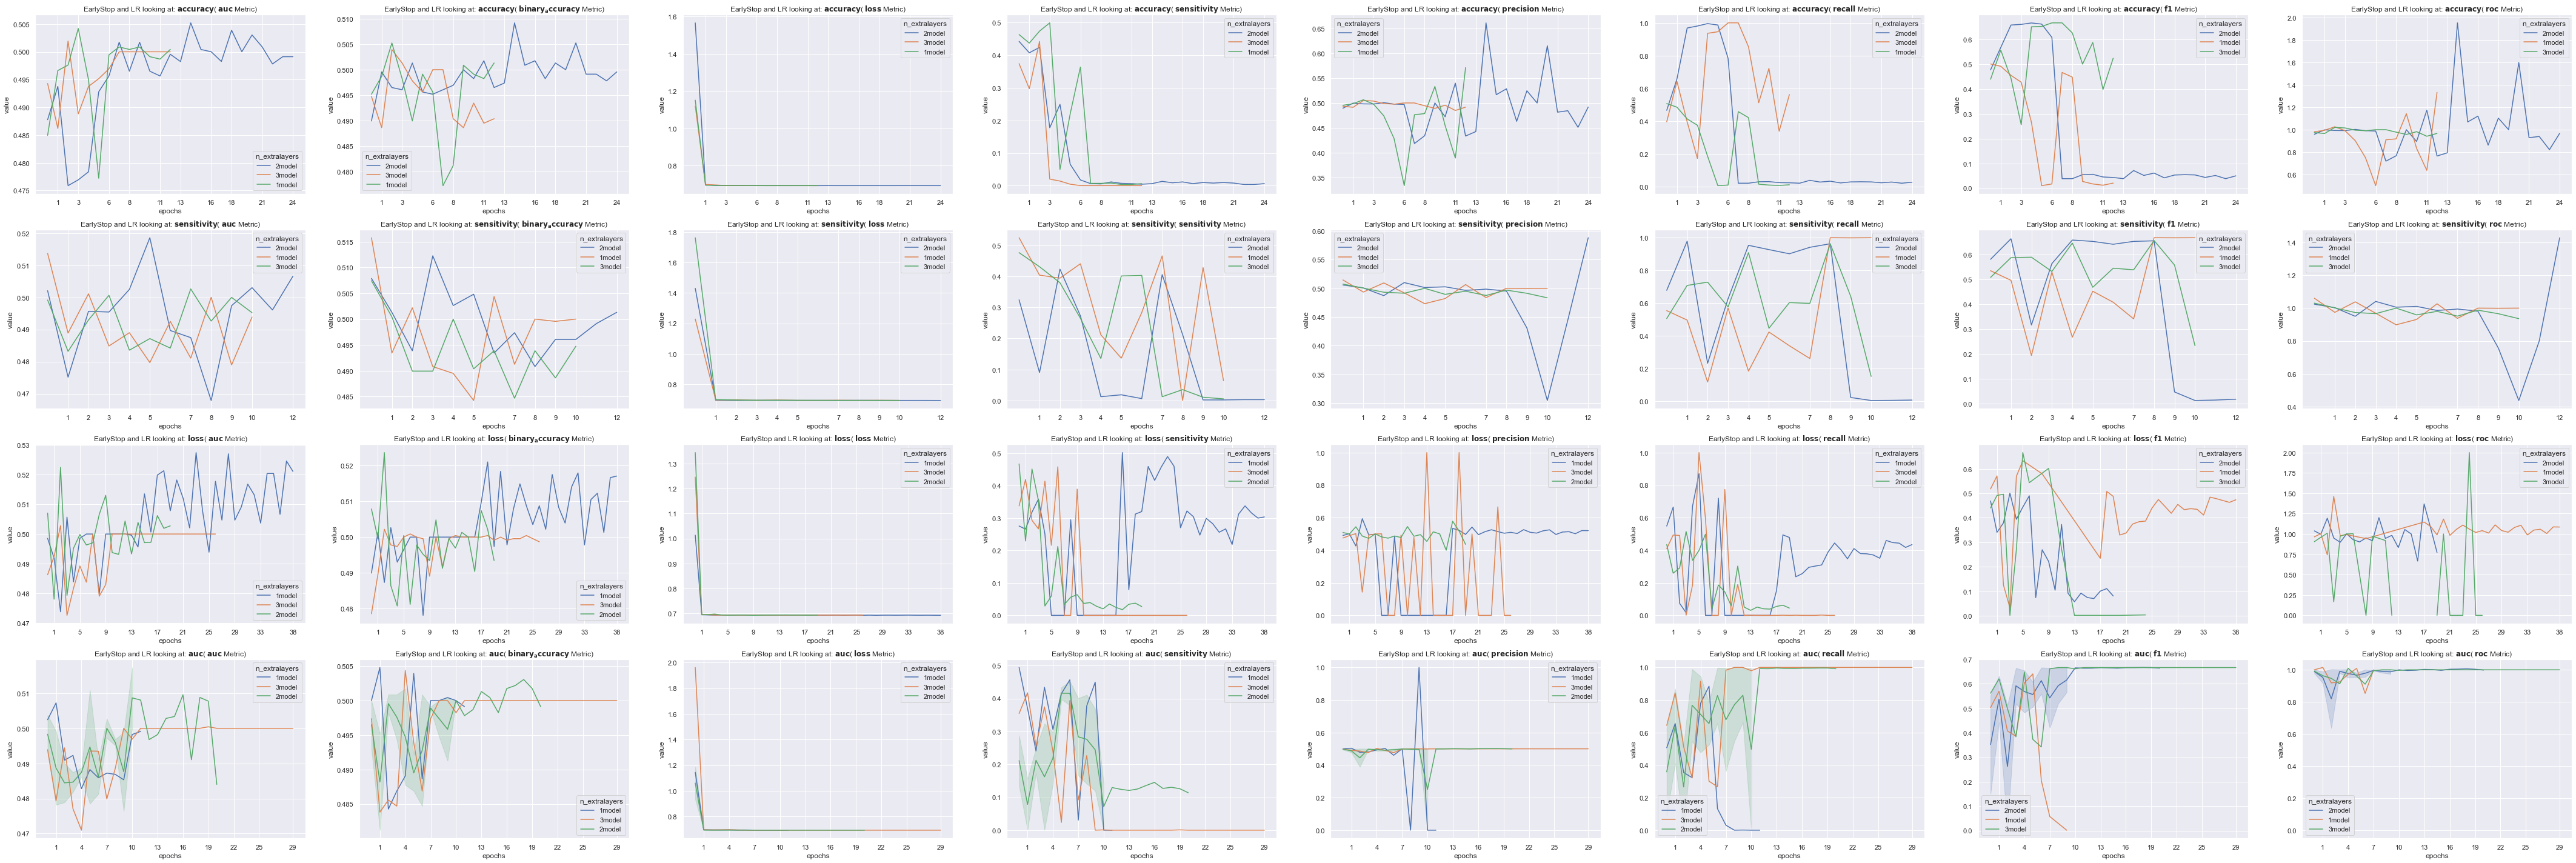

In [292]:
metrics = ['auc', 
          'binary_accuracy', 'loss', 
          'sensitivity', 
          'precision', 'recall', 'f1', 'roc']
target_metrics = df_metrics_resnet.target_metric.unique()

df_present = df_metrics_resnet.loc[df_metrics_resnet.metric.isin(metrics) & 
                                   df_metrics_resnet.target_metric.isin(target_metrics)]
cols = df_present.metric.unique()
rows = df_present.target_metric.unique()

fig, axes = plt.subplots(len(rows), len(cols))
print(len(rows), len(cols))
fig.set_figheight(25)
fig.set_figwidth(75)
# g = sns.relplot(x="index", y="value", kind='line',
sns.set()
axes = axes.ravel()

for row in range(len(rows) ):
    for col in range(len(cols)):
        i = row * len(cols) + col
        print(row, col, i)
#        fig.add_subplot(len(rows), len(cols), i)
        g = sns.lineplot(x="nepoch", y="value",
                    hue="n_extralayers",
                    data=df_present.loc[(df_present.metric == cols[col]) &
                                        (df_present.target_metric == rows[row])
                                       ],
                    ax=axes[i])
        #n_epochs = 
        last_epoch = g.get_xticks()[-1]
        g.set_xlabel('epochs')
        g.set_title(f'EarlyStop and LR looking at: ' +
                    r"$\bf{" + rows[row] +"}$"+ 
                    r"( $\bf{" + cols[col] +"}$ Metric)"
                   )
        g.set_xticks(np.linspace(1, last_epoch, 10, dtype=int))
fig.savefig('metrics_resnet.png')
#        print(type(g))